# Train a VAE on Cell Painting LINCS Data

In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data


from pycytominer.cyto_utils import infer_cp_features


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA
from tensorflow import keras

from vae import VAE

from tensorflow.keras.models import Model, Sequential
import seaborn
import random as python_random
import tensorflow as tf



In [2]:
# %load_ext nb_black

In [19]:
def remove_moa(df):
    pipes = ['aromatase inhibitor|TRPV antagonist'
         'CDK inhibitor|glycogen synthase kinase inhibitor',
             'DNA synthesis inhibitor|microtubule inhibitor',
             'DNA synthesis inhibitor|thymidylate synthase inhibitor',
            'apoptosis stimulant|ribonucleotide reductase inhibitor']    
    moas =  []
    for pipe in pipes:
        moas.append(pipe)
        moas.append(pipe.split('|')[0])
        moas.append(pipe.split('|')[1])
    return df[~df.moa.isin(moas)]

In [20]:
data_splits = ["train", "test", "valid", "complete"]
data_dict = load_data(data_splits)

In [21]:
# Prepare data for training
meta_features = infer_cp_features(data_dict["train"], metadata=True)
cp_features = infer_cp_features(data_dict["train"])

moa_df_train = pd.read_csv("../3.application/repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_sample').reindex(index=data_dict['train']['Metadata_broad_sample']).reset_index().drop('Metadata_broad_sample',axis = 1)
data_dict['train'] = pd.concat([moa_df_train,data_dict['train']], axis=1)

moa_df_valid = pd.read_csv("../3.application/repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_sample').reindex(index=data_dict['valid']['Metadata_broad_sample']).reset_index().drop('Metadata_broad_sample',axis = 1)
data_dict['valid'] = pd.concat([moa_df_valid,data_dict['valid']], axis=1)

data_dict['train'] = remove_moa(data_dict['train'])
data_dict['valid'] = remove_moa(data_dict['valid'])

train_features_df = data_dict["train"].reindex(cp_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(cp_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(cp_features, axis="columns")
valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")


In [22]:
print(train_features_df.shape)
train_features_df.head(3)

(8172, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.56071,0.63708,0.57961,0.51030,0.61695,0.30869,0.43981,0.79826,0.72477,0.68589,...,0.17858,0.29336,0.26447,0.30197,0.64786,0.49525,0.53512,0.40495,0.46056,0.43647
1,0.59702,0.55453,0.62561,0.47959,0.59022,0.33269,0.49875,0.88042,0.67159,0.61703,...,0.09030,0.15088,0.13334,0.14052,0.59229,0.49294,0.43221,0.33969,0.39208,0.36205
2,0.64623,0.59825,0.62822,0.52100,0.57452,0.26367,0.48172,0.86322,0.67588,0.69732,...,0.18125,0.23244,0.20723,0.24062,0.54642,0.43920,0.41183,0.30375,0.35385,0.33266


In [23]:
print(test_features_df.shape)
test_features_df.head(3)

(1037, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.52664,0.59293,0.51636,0.52824,0.54415,0.23948,0.53361,0.84625,0.65881,0.86971,...,0.74413,0.58353,0.54654,0.63600,0.50501,0.39338,0.46080,0.25924,0.29724,0.27556
1,0.61343,0.57882,0.62454,0.51049,0.57508,0.31691,0.49077,0.89145,0.65811,0.66082,...,0.12499,0.20488,0.18676,0.20580,0.58773,0.47783,0.42619,0.34683,0.39642,0.37092
2,0.55123,0.61050,0.53085,0.65280,0.54356,0.16767,0.50521,0.93703,0.77958,0.63413,...,0.19249,0.13665,0.13293,0.13816,0.58333,0.52931,0.31068,0.40967,0.48646,0.45058


In [24]:
print(complete_features_df.shape)
complete_features_df.head(3)

(10368, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.57016,0.59500,0.57370,0.50690,0.56160,0.27321,0.45448,0.83747,0.68635,0.68973,...,0.16426,0.22701,0.20854,0.22897,0.53738,0.43547,0.41635,0.28933,0.34017,0.31368
1,0.54840,0.53949,0.58096,0.53694,0.55009,0.28114,0.53594,0.86929,0.66026,0.71317,...,0.18411,0.23932,0.21854,0.24763,0.56995,0.47084,0.37764,0.32148,0.36964,0.34328
2,0.56057,0.59621,0.59116,0.50418,0.55679,0.29305,0.49221,0.87813,0.71747,0.72229,...,0.17564,0.23366,0.21743,0.23448,0.56980,0.47254,0.39575,0.31969,0.36626,0.34086


In [25]:
# VAE of one layer
encoder_architecture = [250]
decoder_architecture = [250]



In [26]:
# model from optimal hyperparameters for onelayer obtained from 1.optimize
cp_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=10,
    batch_size=96,
    encoder_batch_norm=True,
    epochs=100,
    learning_rate=0.001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=.3,
    verbose=True,
)
cp_vae.compile_vae()

In [27]:
cp_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/100
86/86 [==============================] - 10s 33ms/step - loss: 63.6863 - recon: 29.0136 - kl: 0.8459 - mmd: 0.0000e+00 - val_loss: 20.8610 - val_recon: 19.0074 - val_kl: 1.8536 - val_mmd: 0.0000e+00
Epoch 2/100
86/86 [==============================] - 1s 16ms/step - loss: 8.3735 - recon: 7.1433 - kl: 0.7090 - mmd: 0.0000e+00 - val_loss: 7.2847 - val_recon: 6.3266 - val_kl: 0.9581 - val_mmd: 0.0000e+00
Epoch 3/100
86/86 [==============================] - 1s 14ms/step - loss: 6.3709 - recon: 5.4076 - kl: 0.6698 - mmd: 0.0000e+00 - val_loss: 5.9675 - val_recon: 5.0923 - val_kl: 0.8751 - val_mmd: 0.0000e+00
Epoch 4/100
86/86 [==============================] - 1s 13ms/step - loss: 5.2807 - recon: 4.3303 - kl: 0.6410 - mmd: 0.0000e+00 - val_loss: 4.7081 - val_recon: 4.0545 - val_kl: 0.6536 - val_mmd: 0.0000e+00
Epoch 5/100
86/86 [==============================] - 1s 13ms/step - loss: 4.4900 - recon: 3.6715 - kl: 0.6311 - mmd: 0.0000e+00 - val_loss: 4.2093 - val_recon: 3.4753 - va

Epoch 41/100
86/86 [==============================] - 1s 12ms/step - loss: 2.6856 - recon: 1.9947 - kl: 0.7303 - mmd: 0.0000e+00 - val_loss: 2.7268 - val_recon: 2.0115 - val_kl: 0.7153 - val_mmd: 0.0000e+00
Epoch 42/100
86/86 [==============================] - 1s 16ms/step - loss: 2.8097 - recon: 2.0281 - kl: 0.7305 - mmd: 0.0000e+00 - val_loss: 2.7474 - val_recon: 1.9320 - val_kl: 0.8154 - val_mmd: 0.0000e+00
Epoch 43/100
86/86 [==============================] - 1s 15ms/step - loss: 2.6199 - recon: 1.9688 - kl: 0.7317 - mmd: 0.0000e+00 - val_loss: 2.7672 - val_recon: 1.9638 - val_kl: 0.8034 - val_mmd: 0.0000e+00
Epoch 44/100
86/86 [==============================] - 1s 14ms/step - loss: 2.7269 - recon: 1.9870 - kl: 0.7338 - mmd: 0.0000e+00 - val_loss: 2.7042 - val_recon: 1.8074 - val_kl: 0.8968 - val_mmd: 0.0000e+00
Epoch 45/100
86/86 [==============================] - 1s 14ms/step - loss: 2.7470 - recon: 1.9809 - kl: 0.7287 - mmd: 0.0000e+00 - val_loss: 2.6549 - val_recon: 1.9023 - va

In [28]:
cp_vae.vae

In [62]:
# cp_vae.vae.evaluate(test_features_df)

In [31]:
# Save training performance
history_df = pd.DataFrame(cp_vae.vae.history.history)
history_df

,loss,recon,kl,mmd,val_loss,val_recon,val_kl,val_mmd
0,29.859507,29.013628,0.845868,0.0,20.861000,19.007427,1.853573,0.0
1,7.852301,7.143307,0.708995,0.0,7.284726,6.326608,0.958118,0.0
2,6.077443,5.407633,0.669811,0.0,5.967452,5.092325,0.875126,0.0
3,4.971236,4.330263,0.640974,0.0,4.708082,4.054507,0.653576,0.0
4,4.302563,3.671461,0.631102,0.0,4.209323,3.475266,0.734056,0.0
...,...,...,...,...,...,...,...,...
95,2.420530,1.643157,0.777373,0.0,2.354917,1.649162,0.705755,0.0
96,2.425461,1.648945,0.776516,0.0,2.496354,1.693873,0.802481,0.0
97,2.388849,1.606446,0.782404,0.0,2.423533,1.533145,0.890388,0.0
98,2.416160,1.635953,0.780207,0.0,2.455730,1.675995,0.779735,0.0


In [32]:
history_df.to_csv('level5_training_leaveOut.csv')

In [33]:
# history_df = pd.read_csv('level5_training.csv')

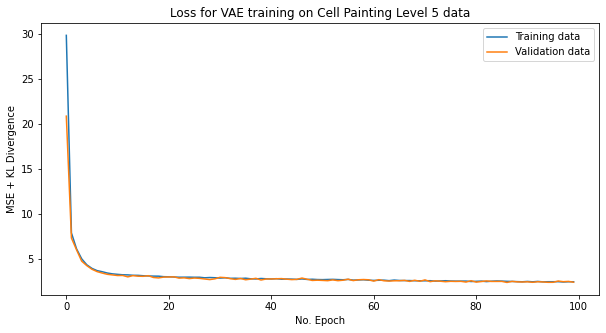

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.title("Loss for VAE training on Cell Painting Level 5 data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()

In [35]:
reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
(sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5

40.470548820721824

<AxesSubplot:>

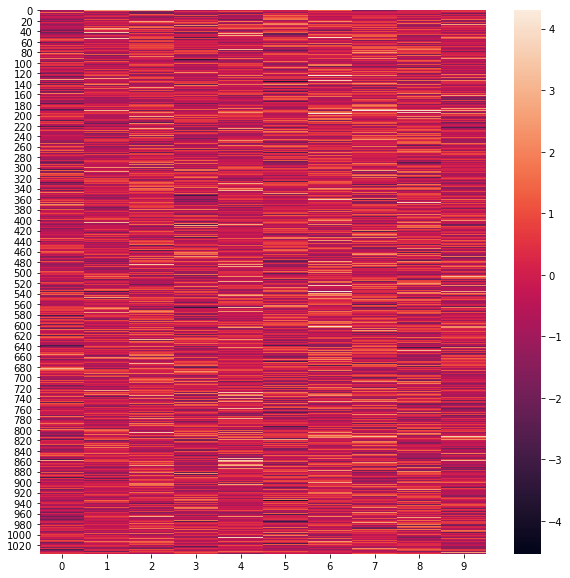

In [36]:
#latent space heatmap
fig, ax = plt.subplots(figsize=(10, 10))
encoder = cp_vae.encoder_block["encoder"]
latent = np.array(encoder.predict(test_features_df)[2])
seaborn.heatmap(latent, ax=ax)

In [37]:
#original vs reconstructed heatmap
reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
pca = PCA(n_components=2).fit(test_features_df)
pca_reconstructed_latent_df = pd.DataFrame(pca.transform(reconstruction))
pca_test_latent_df = pd.DataFrame(pca.transform(test_features_df))
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
# seaborn.heatmap(test_features_df, ax=ax1)
# seaborn.heatmap(reconstruction, ax=ax2)
# plt.show()

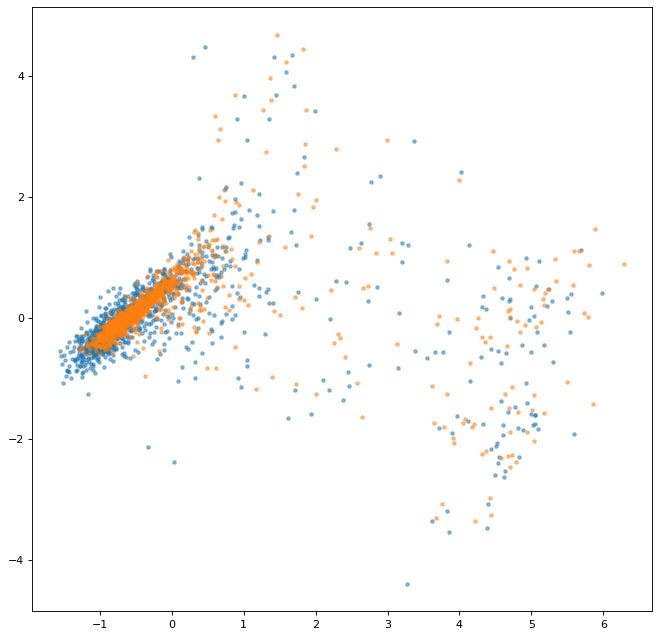

In [38]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_test_latent_df[0],pca_test_latent_df[1], marker = ".", alpha = 0.5)
plt.scatter(pca_reconstructed_latent_df[0],pca_reconstructed_latent_df[1], marker = ".", alpha = 0.5)

In [42]:
# decoder = keras.models.load_model("level5Decoder")
# encoder = keras.models.load_model("level5Encoder")

In [43]:
# reconstruction = decoder.predict(encoder.predict(test_features_df)[2])

In [39]:
import umap
reducer = umap.UMAP().fit(test_features_df)
original_test_embedding = reducer.transform(test_features_df)
reconstructed_test_embedding = reducer.transform(reconstruction)

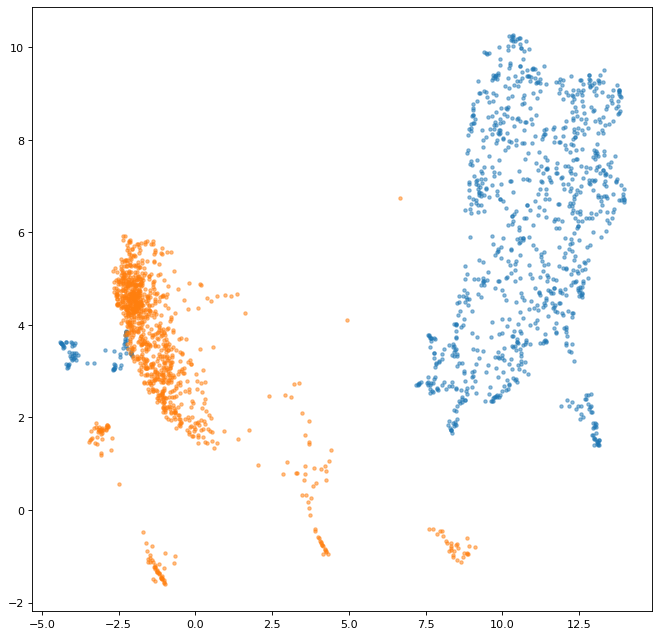

In [40]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(original_test_embedding[:,0],original_test_embedding[:,1], marker = ".", alpha = 0.5)
plt.scatter(reconstructed_test_embedding[:,0],reconstructed_test_embedding[:,1], marker = ".", alpha = 0.5)

<AxesSubplot:>

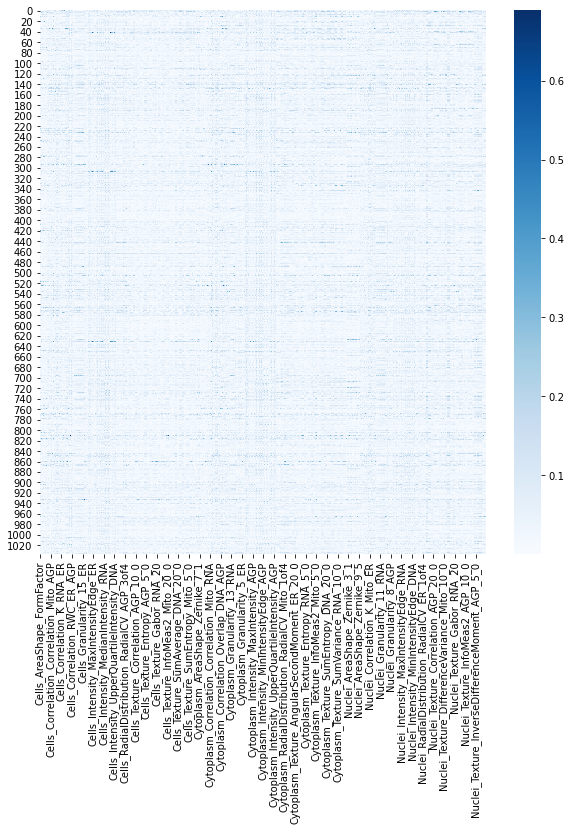

In [130]:
#difference between original and reconstructed heatmap
difference = abs(reconstruction - test_features_df)
fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(difference, ax=ax, cmap="Blues")

<AxesSubplot:>

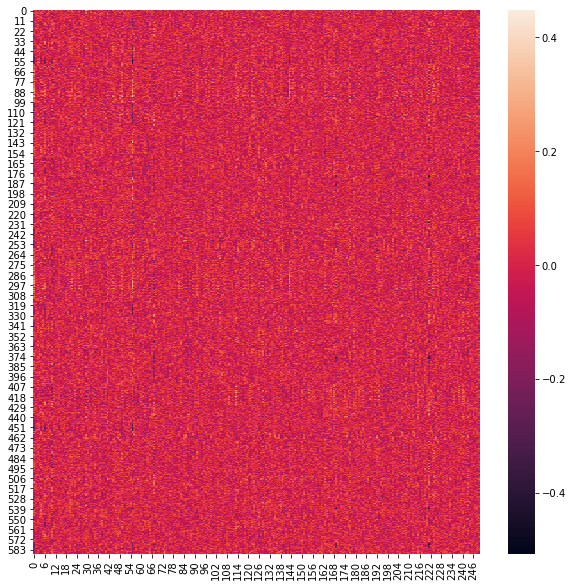

In [131]:
#encoder heatmap
weights = cp_vae.encoder_block["encoder"].get_weights()
fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(weights[0], ax=ax)

In [398]:
frobenius_norms = []
for reconstruction in reconstructions:
    frobenius_norms.append(
        (sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5
    )

NameError: name 'reconstructions' is not defined

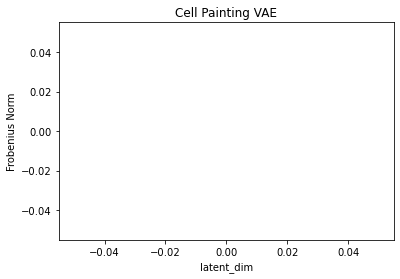

In [399]:
plt.plot(frobenius_norms)
plt.xlabel("latent_dim")
plt.ylabel("Frobenius Norm")
plt.title("Cell Painting VAE")
plt.show()

In [41]:
decoder = cp_vae.decoder_block["decoder"]

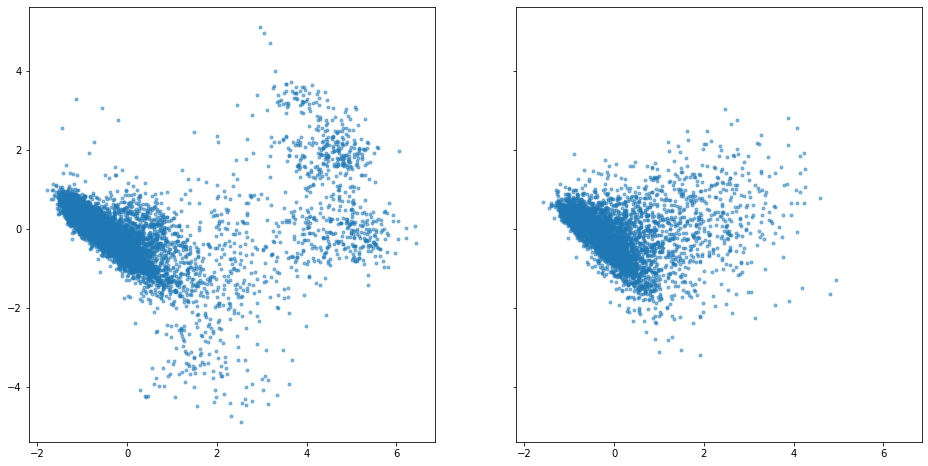

In [42]:

pca_training = PCA(n_components=2).fit(train_features_df)

simulated_df = pd.DataFrame(np.random.normal(size=(8294, 10)), columns=np.arange(0,10))
reconstruction_of_simulated = decoder.predict(simulated_df)
pca_reconstruction_of_simulated = pd.DataFrame(pca_training.transform(reconstruction_of_simulated))
pca_train_latent_df = pd.DataFrame(pca_training.transform(train_features_df))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8), sharey = True, sharex = True)
ax1.scatter(pca_train_latent_df[0],pca_train_latent_df[1], marker = ".", alpha = 0.5)
ax2.scatter(pca_reconstruction_of_simulated[0],pca_reconstruction_of_simulated[1], marker = ".", alpha = 0.5)

In [43]:
from scipy.spatial.distance import directed_hausdorff
max(directed_hausdorff(reconstruction_of_simulated, train_features_df)[0],directed_hausdorff(train_features_df,reconstruction_of_simulated)[0])

5.37825188653358

In [12]:
decoder = keras.models.load_model("level5Decoder")

In [43]:
import umap
reducer = umap.UMAP()
original_test_embedding = reducer.fit_transform(test_features_df)

In [44]:
simulated_test_df = pd.DataFrame(np.random.normal(size=(1037, 10)), columns=np.arange(0,10))
reconstruction_of_simulated_test = decoder.predict(simulated_test_df)

In [45]:
simulated_embedding = reducer.transform(reconstruction_of_simulated_test)

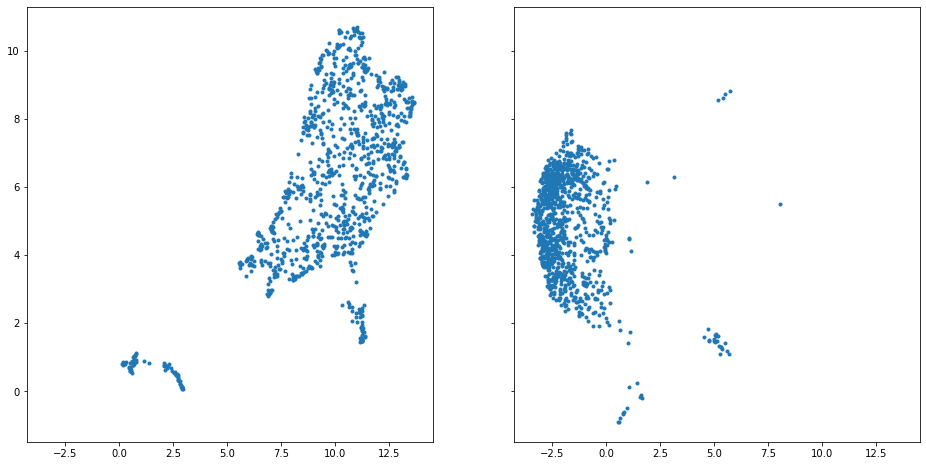

In [46]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8), sharey = True, sharex = True)
ax1.scatter(
    original_test_embedding[:, 0],
    original_test_embedding[:, 1],
#     c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})]
    marker = '.'
)
ax2.scatter(
    simulated_embedding[:, 0],
    simulated_embedding[:, 1],
#     c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})]
    marker = '.'
)
# plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection of the cell painting level 5 test set')

In [44]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
latent_complete = np.array(encoder.predict(complete_features_df)[2])
latent_df = pd.DataFrame(latent_complete)
latent_df.to_csv("../3.application/level5Latent_leaveOut.csv")

In [45]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
decoder.save("level5Decoder_leaveOut")

INFO:tensorflow:Assets written to: level5Decoder_leaveOut/assets


In [46]:
encoder.save("level5Encoder_leaveOut")

INFO:tensorflow:Assets written to: level5Encoder_leaveOut/assets
